In [1]:
import pandas as pd
import geopandas as gpd
import os
import glob
import matplotlib.pyplot as plt
import seaborn as sns
from seaborn import palplot
import contextily as cx
import palettable as pltt
import sklearn
from sklearn.cluster import DBSCAN
import sklearn.metrics as metrics

In [2]:
df=pd.read_csv('CombinedSub.csv')
addressbase=pd.read_csv('addressbase-product-classification-scheme.csv')
polygons=gpd.read_file('Rossendale.gml')

plt.style.use('seaborn-deep')

C:\JupyterLab\resources\jlab_server\lib\site-packages\IPython\core\interactiveshell.py:3444: DtypeWarning: Columns (0,1,3,4,5,6,7,8,9,10,11,12,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [125]:
polygons.head()

gml_id  INSPIREID     LABEL  \
0  PREDEFINED.fid-300398cc_17e18ffa75f_-7cc   22327664  22327664   
1  PREDEFINED.fid-300398cc_17e18ffa75f_-7cb   22185184  22185184   
2  PREDEFINED.fid-300398cc_17e18ffa75f_-7ca   56532643  56532643   
3  PREDEFINED.fid-300398cc_17e18ffa75f_-7c9   22199342  22199342   
4  PREDEFINED.fid-300398cc_17e18ffa75f_-7c8   22185048  22185048   

   NATIONALCADASTRALREFERENCE                 VALIDFROM  \
0                    22327664  2008-07-11T08:51:08.142Z   
1                    22185184  2009-02-24T13:16:07.987Z   
2                    56532643      2014-07-30T23:00:00Z   
3                    22199342      2009-02-24T00:00:00Z   
4                    22185048  2009-02-24T14:24:19.991Z   

       BEGINLIFESPANVERSION                                           geometry  
0  2008-07-11T08:51:08.142Z  POLYGON ((390452.560 422859.550, 390450.450 42...  
1  2009-02-24T13:16:07.987Z  POLYGON ((390101.515 421982.899, 390117.342 42...  
2  2014-07-31T13:45:20.285Z  POLYGON ((390209.719 420625.550, 390223.710 42...  
3  2009-02-24T13:18:51.518Z  POLYGON ((390255.260 421720.050, 390262.490 42...  
4  2009-02-24T14:24:19.991Z  POLYGON ((390264.540 421259.260, 390266.040 42...

In [3]:
df.head()

UPRN      UDPRN CHANGE_TYPE STATE   STATE_DATE CLASS PARENT_UPRN  \
0  X100010596925  X18010433           I    X2  X2010.07.07  RD04           X   
1    1.00011E+11   18010535           I     2   08/07/2010  RD03         NaN   
2    1.00011E+11   18011474           I     2   08/07/2010  RD04         NaN   
3    1.00011E+11   18011251           I     2   21/12/2007  RD06         NaN   
4    1.00011E+11   18011262           I     2   21/12/2007  RD03         NaN   

  X_COORDINATE Y_COORDINATE     LATITUDE  ... DELIVERY_POINT_SUFFIX  \
0   X387068.00   X422828.00  X53.7017377  ...                   X1E   
1       387334       422732   53.7008815  ...                    1P   
2       387264       422459   53.6984261  ...                    1G   
3       387192       422313    53.697112  ...                    1Z   
4       387146       422312   53.6971019  ...                    2P   

  ADDRESSBASE_POSTAL PO_BOX_NUMBER  WARD_CODE PARISH_CODE RM_START_DATE  \
0                  D          X.31  E05005325        X.32   X2012.03.19   
1                  D           NaN  E05005325         NaN    19/03/2012   
2                  D           NaN  E05005325         NaN    19/03/2012   
3                  D           NaN  E05005325         NaN    19/03/2012   
4                  D           NaN  E05005325         NaN    19/03/2012   

  MULTI_OCC_COUNT VOA_NDR_P_DESC_CODE VOA_NDR_SCAT_CODE ALT_LANGUAGE  
0              X0                X.33              X.34         X.35  
1               0                 NaN               NaN          NaN  
2               0                 NaN               NaN          NaN  
3               0                 NaN               NaN          NaN  
4               0                 NaN               NaN          NaN  

[5 rows x 77 columns]

In [4]:
df=df.drop(index=0, axis=0,) # remove top row

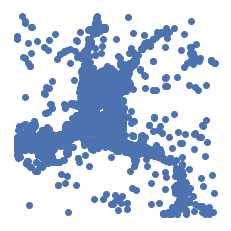

In [5]:
# Convert df to gdf:
gdf=gpd.GeoDataFrame(df, 
                     geometry=gpd.points_from_xy(x=df.X_COORDINATE, y=df.Y_COORDINATE), 
                     crs='EPSG:27700'
                    )
gdf.plot().set_axis_off()

In [88]:
xmin, ymin, xmax, ymax=gdf.total_bounds
bounds=polygons.cx[xmin:xmax, ymin:ymax]

xlim=([gdf.total_bounds[0]-100,  gdf.total_bounds[2]+100])
ylim=([gdf.total_bounds[1]-100,  gdf.total_bounds[3]+100])

In [7]:
# View all retail types:
codes=addressbase[addressbase['Concatenated'].str.startswith('CR')]

In [8]:
sub=gdf[gdf['CLASS'].notna()] # drop rows in class column with NaN values
filt=sub[sub['CLASS'].str.startswith('CR')] # filter class column starting with CR

In [9]:
filt.head()

UPRN     UDPRN CHANGE_TYPE STATE  STATE_DATE CLASS  PARENT_UPRN  \
57   10014224109  54340530           I     2  04/04/2011  CR08  10014224105   
169  10014329966       NaN           I     2  04/11/2008  CR02          NaN   
216  1.00013E+11       NaN           I     2  25/03/2008  CR08          NaN   
263  1.00013E+11  18009599           I     2  21/12/2007  CR08          NaN   
275  1.00013E+11  18009601           I     2  31/03/2011  CR08          NaN   

    X_COORDINATE Y_COORDINATE    LATITUDE  ... ADDRESSBASE_POSTAL  \
57        386638       422130  53.6954533  ...                  D   
169       387347       422391  53.6978169  ...                  L   
216    386846.92    422832.93  53.7017765  ...                  L   
263       386927       423006   53.703334  ...                  D   
275       386917       423018  53.7034416  ...                  D   

    PO_BOX_NUMBER  WARD_CODE PARISH_CODE RM_START_DATE MULTI_OCC_COUNT  \
57            NaN  E05005321         NaN    20/05/2016               0   
169           NaN  E05005325         NaN           NaN               0   
216           NaN  E05005321         NaN           NaN               0   
263           NaN  E05005325         NaN    19/03/2012               3   
275           NaN  E05005325         NaN    19/03/2012               0   

    VOA_NDR_P_DESC_CODE VOA_NDR_SCAT_CODE ALT_LANGUAGE  \
57                   CW                96          NaN   
169                 NaN               NaN          NaN   
216                  CS               249          NaN   
263                 NaN               NaN          NaN   
275                  CO               203          NaN   

                          geometry  
57   POINT (386638.000 422130.000)  
169  POINT (387347.000 422391.000)  
216  POINT (386846.920 422832.930)  
263  POINT (386927.000 423006.000)  
275  POINT (386917.000 423018.000)  

[5 rows x 78 columns]

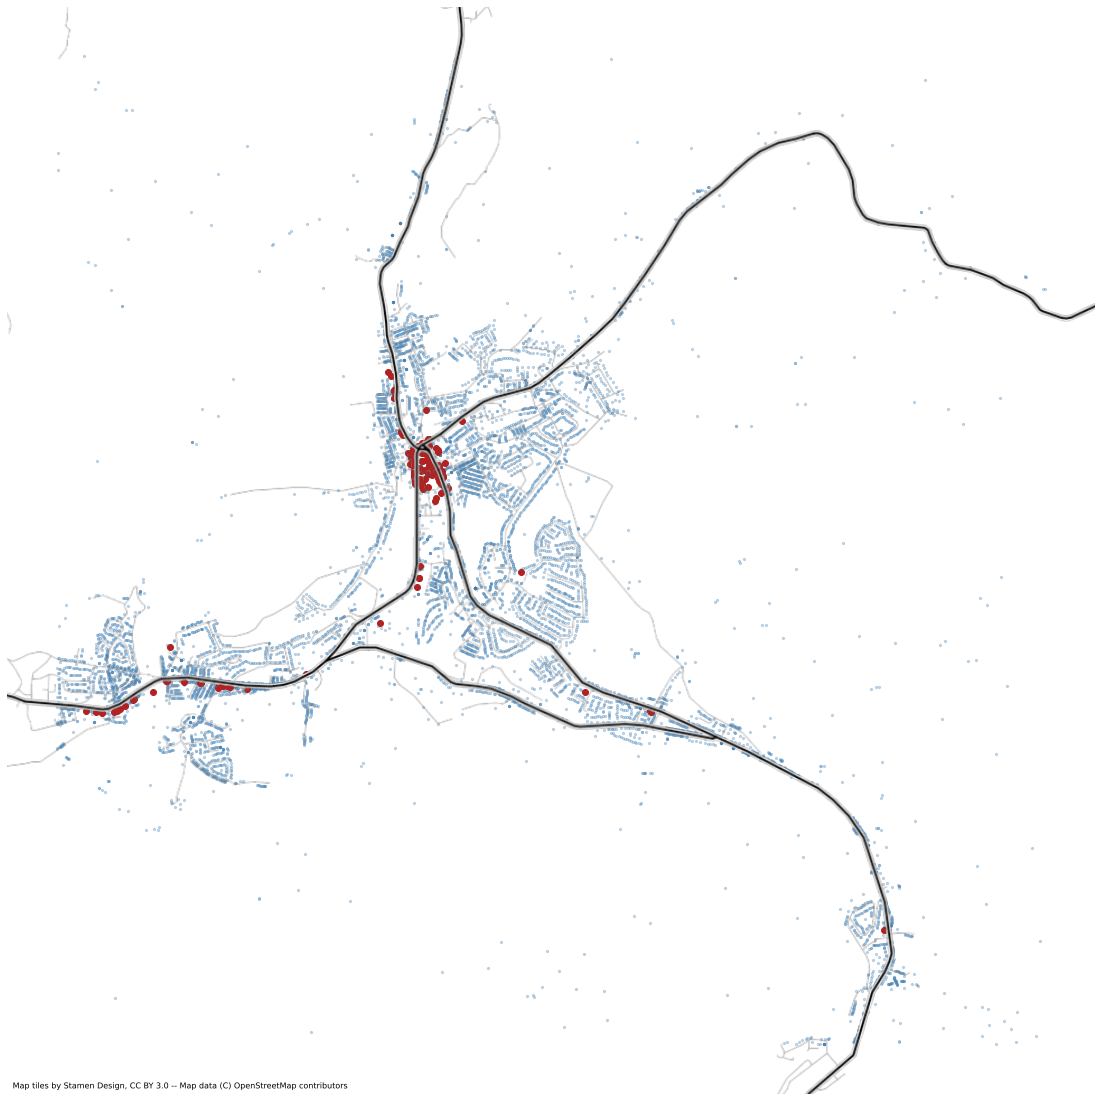

In [118]:
# plot retail (gold) and all properties (blue):
f, ax=plt.subplots(1,
                  figsize=(20,20)
                 )

gdf.plot(ax=ax,
         marker='.',
         markersize=20,
         color='steelblue',
         alpha=0.3
         )
filt.plot(ax=ax,
          marker='o',
          color='firebrick',
          legend=True
        )

cx.add_basemap(ax=ax,
               crs=gdf.crs,
               source=cx.providers.Stamen.TonerLines
              )
ax.set_axis_off()
plt.savefig('1 Retail Points')

In [12]:
filt_sub=filt[['X_COORDINATE', 'Y_COORDINATE']] # subset for DBSCAN

In [13]:
# Convert coordinates to float in order for DBSCAN to work:
filt_sub['X_COORDINATE']=filt_sub['X_COORDINATE'].astype(float)
filt_sub['Y_COORDINATE']=filt_sub['Y_COORDINATE'].astype(float)

# Check:
filt_sub.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1739 entries, 57 to 201696
Data columns (total 2 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   X_COORDINATE  165 non-null    float64
 1   Y_COORDINATE  165 non-null    float64
dtypes: float64(2)
memory usage: 40.8 KB


C:\Temp/ipykernel_15396/1611041430.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filt_sub['X_COORDINATE']=filt_sub['X_COORDINATE'].astype(float)
C:\Temp/ipykernel_15396/1611041430.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filt_sub['Y_COORDINATE']=filt_sub['Y_COORDINATE'].astype(float)


In [14]:
filt_sub=filt_sub[filt_sub['X_COORDINATE'].notna()]
filt_sub.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 165 entries, 57 to 8620
Data columns (total 2 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   X_COORDINATE  165 non-null    float64
 1   Y_COORDINATE  165 non-null    float64
dtypes: float64(2)
memory usage: 3.9 KB


In [15]:
# Specify DBSCAN model (150m radius, minimum 5 instances per cluster):
dbscan=DBSCAN(eps=150, min_samples=5)

# Fit model and display silhouette score:
dbscan.fit(filt_sub)
dbscan_labels=dbscan.labels_
metrics.silhouette_score(filt_sub, dbscan_labels)

0.6343857098142606

In [16]:
# Add DBSCAN labels as column:
filt_sub['dClusters']=dbscan_labels

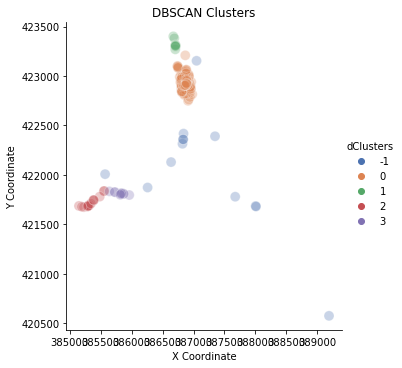

In [17]:
# Plot DBSCAN clusters:
# sns.set_palette(sns.color_palette(wes))
fig = sns.relplot(data=filt_sub, 
                  x='X_COORDINATE',
                  y='Y_COORDINATE', 
                  s=100, 
                  hue='dClusters', 
                  palette='deep',
                  alpha=0.3)
plt.xlabel('X Coordinate') 
plt.ylabel('Y Coordinate') 
plt.title('DBSCAN Clusters')
plt.show() 

In [18]:
# Convert filt_sub to gdf so it can be plotted with other geodata on map:
filt_sub_gdf=gpd.GeoDataFrame(filt_sub, 
                              geometry=gpd.points_from_xy(x=filt_sub.X_COORDINATE, y=filt_sub.Y_COORDINATE), 
                              crs='EPSG:27700'
                             )
filt_sub_gdf.head()

X_COORDINATE  Y_COORDINATE  dClusters                       geometry
57      386638.00     422130.00         -1  POINT (386638.000 422130.000)
169     387347.00     422391.00         -1  POINT (387347.000 422391.000)
216     386846.92     422832.93          0  POINT (386846.920 422832.930)
263     386927.00     423006.00          0  POINT (386927.000 423006.000)
275     386917.00     423018.00          0  POINT (386917.000 423018.000)

In [19]:
# Create new DataFrame, only contains points in DBSCAN clusters:
high_st=filt_sub_gdf[filt_sub_gdf['dClusters']>=0]

In [119]:
# plot propery polygons and retail units on map. 
fig, ax=plt.subplots(1,
                     figsize=(20,40)
                    )

ax.set_xlim(xlim)
ax.set_ylim(ylim)

polygons.plot(ax=ax, 
              facecolor='none', 
              edgecolor='black', 
              linewidth=0.2,
             )

gdf.plot(ax=ax,
         marker='.',
         color='steelblue',
         markersize=20,
         alpha=0.6
         )

filt.plot(ax=ax, 
          marker='o',
          color='firebrick', 
          alpha=1
         )

cx.add_basemap(ax=ax,
               crs=filt.crs,
               source=cx.providers.Stamen.TonerLines,
              )



ax.set_axis_off()
plt.savefig('2 Points and Polygons')

In [21]:
# Spatial join to return only the polygons containing a point, ie retail polygons:
retail_poly=gpd.sjoin(polygons,
                       filt,
                       op='intersects'
                      )
retail_poly['Retail Units']=1

retail_poly.plot()

C:\JupyterLab\resources\jlab_server\lib\site-packages\IPython\core\interactiveshell.py:3364: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if (await self.run_code(code, result,  async_=asy)):


<AxesSubplot:>

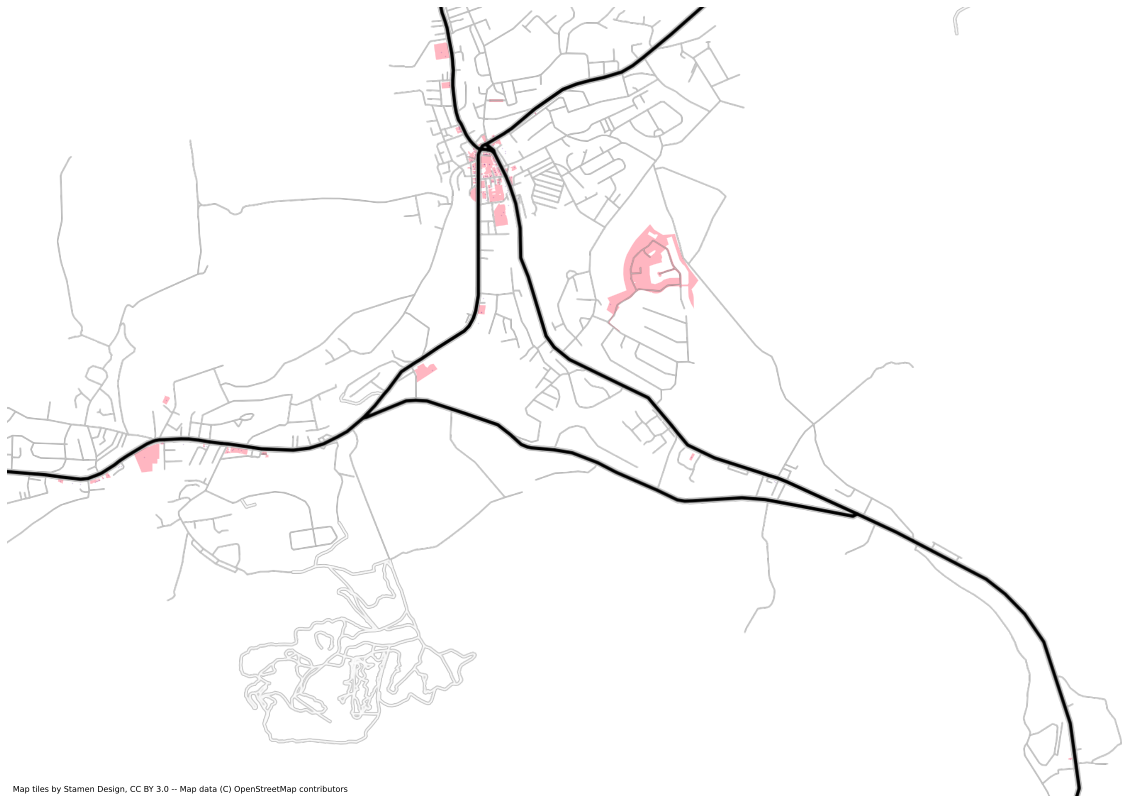

In [87]:
# plot retail points and polygons:
fig, ax=plt.subplots(1,
                     figsize=(20,20)
                    )

retail_poly.plot(ax=ax, 
              facecolor='lightpink', 
              edgecolor='white', 
              linewidth=0.2
             )

filt.plot(ax=ax, 
                color='indigo', 
                linewidth=0.5, 
                markersize=10, 
                alpha=0.7
            )

cx.add_basemap(ax=ax,
               crs=filt.crs,
               source=cx.providers.Stamen.TonerLines,
              )

ax.set_axis_off()
plt.show()

In [23]:
# plot retail points and polygons on map:
f, ax=plt.subplots(1,
                  figsize=(20,20)
                 )

retail_poly.plot(ax=ax, 
                 facecolor='lightcoral', 
                 edgecolor='white', 
                 linewidth=0.2
                )

filt.plot(ax=ax,
          color='blue',
          marker='^',
          legend=True
         )

cx.add_basemap(ax=ax,
               crs=filt.crs,
               source=cx.providers.Stamen.Toner
              )
ax.set_axis_off()

C:\JupyterLab\resources\jlab_server\lib\site-packages\IPython\core\interactiveshell.py:3364: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if (await self.run_code(code, result,  async_=asy)):


<AxesSubplot:>

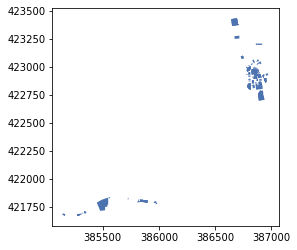

In [24]:
high_st_poly=gpd.sjoin(polygons,
                       high_st,
                       op='intersects'
                      )
high_st_poly['Retail Units']=1

high_st_poly.plot()

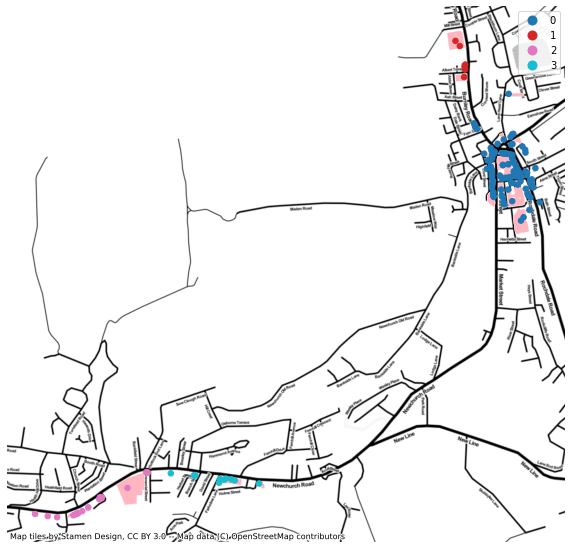

In [25]:
f, ax=plt.subplots(1,
                  figsize=(10,10)
                 )

high_st_poly.plot(ax=ax, 
              facecolor='lightpink', 
              edgecolor='white', 
              linewidth=0.2
             )

high_st.plot(ax=ax,
             markersize=30,
             column='dClusters',
             cmap='tab10',
             categorical=True,
             legend=True
        )

cx.add_basemap(ax=ax,
               crs=filt.crs,
               source=cx.providers.Stamen.Toner
              )
ax.set_axis_off()
plt.savefig('High St Points')

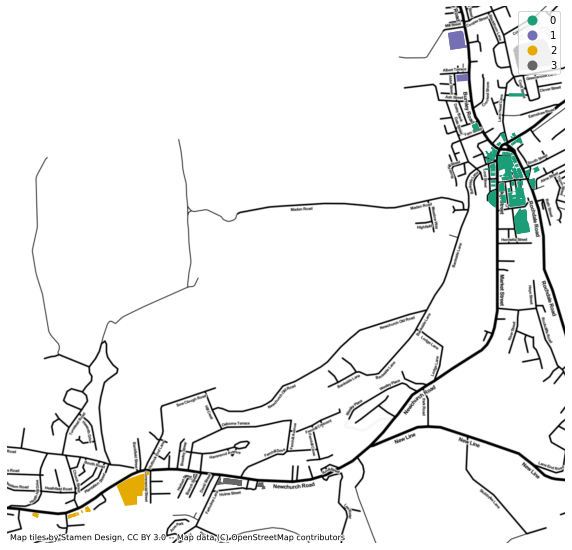

In [33]:
fig, ax=plt.subplots(1,
                  figsize=(10,10)
                 )

high_st_poly.plot(ax=ax, 
                  column='dClusters',
                  cmap='Dark2',
                  categorical=True,
                  legend=True,
                  linewidth=0.2
             )
        
cx.add_basemap(ax=ax,
               crs=filt.crs,
               source=cx.providers.Stamen.Toner
              )
ax.set_axis_off()
plt.savefig('High St Clusters.png')

In [29]:
fig, ax=plt.subplots(1,
                  figsize=(10,10)
                 )

high_st_poly.plot(ax=ax, 
                  color='lightcoral',
                  legend=True,
                  linewidth=0.2
             )
        
cx.add_basemap(ax=ax,
               crs=filt.crs,
               source=cx.providers.Stamen.Toner
              )
ax.set_axis_off()
plt.show()

In [120]:
fig, ax=plt.subplots(1,
                     figsize=(20,40)
                    )

ax.set_xlim(xlim)
ax.set_ylim(ylim)

polygons.plot(ax=ax, 
              facecolor='None', 
              edgecolor='black', 
              linewidth=0.2,
              
             )

# gdf.plot(ax=ax,
#          color='steelblue',
#          markersize=10,
#          alpha=0.7
#          )

retail_poly.plot(ax=ax,
                 color='firebrick'
                )

# high_st_poly.plot(ax=ax, 
#                   color='gold',
#                  )


cx.add_basemap(ax=ax,
               crs=filt.crs,
               source=cx.providers.Stamen.TonerLines,
              )



ax.set_axis_off()
plt.savefig('3 Retail Poly')

In [121]:
fig, ax=plt.subplots(1,
                     figsize=(20,40)
                    )

ax.set_xlim(xlim)
ax.set_ylim(ylim)

polygons.plot(ax=ax, 
              facecolor='None', 
              edgecolor='black', 
              linewidth=0.2,
              
             )

# gdf.plot(ax=ax,
#          color='steelblue',
#          markersize=10,
#          alpha=0.7
#          )

retail_poly.plot(ax=ax,
                 color='firebrick'
                )

high_st_poly.plot(ax=ax, 
                  color='gold',
                  # column='dClusters'
                 )


cx.add_basemap(ax=ax,
               crs=filt.crs,
               source=cx.providers.Stamen.TonerLines,
              )



ax.set_axis_off()
plt.savefig('4 High St Poly')

In [122]:
fig, ax=plt.subplots(1,
                     figsize=(20,40)
                    )

ax.set_xlim(xlim)
ax.set_ylim(ylim)

polygons.plot(ax=ax, 
              facecolor='None', 
              edgecolor='black', 
              linewidth=0.2,
              
             )

# gdf.plot(ax=ax,
#          color='steelblue',
#          markersize=10,
#          alpha=0.7
#          )

# retail_poly.plot(ax=ax,
#                  color='firebrick',
#                  alpha=0
#                 )

high_st_poly.plot(ax=ax, 
                  # color='gold',
                  column='dClusters',
                  # cmap='tab20',
                  categorical=True,
                  legend=True
                 )


cx.add_basemap(ax=ax,
               crs=filt.crs,
               source=cx.providers.Stamen.TonerLines,
              )



ax.set_axis_off()
plt.savefig('5 Clusters')

In [79]:
fig, ax=plt.subplots(1,
                     figsize=(20,40)
                    )

ax.set_xlim(xlim)
ax.set_ylim(ylim)

polygons.plot(ax=ax, 
              facecolor='None', 
              edgecolor='black', 
              linewidth=0.2,
              
             )



retail_poly.plot(ax=ax,
                 color='gold'
                )

high_st_poly.plot(ax=ax, 
                  color='lightcoral',
                 )

filt.plot(ax=ax,
          color='steelblue',
          markersize=40,
          legend=True,
          alpha=0.7
         )
         

cx.add_basemap(ax=ax,
               crs=filt.crs,
               source=cx.providers.Stamen.TonerLines,
              )



ax.set_axis_off()
plt.show()

In [32]:
filt.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 1739 entries, 57 to 201696
Data columns (total 78 columns):
 #   Column                           Non-Null Count  Dtype   
---  ------                           --------------  -----   
 0   UPRN                             165 non-null    object  
 1   UDPRN                            129 non-null    object  
 2   CHANGE_TYPE                      1739 non-null   object  
 3   STATE                            1656 non-null   object  
 4   STATE_DATE                       165 non-null    object  
 5   CLASS                            1739 non-null   object  
 6   PARENT_UPRN                      543 non-null    object  
 7   X_COORDINATE                     165 non-null    object  
 8   Y_COORDINATE                     165 non-null    object  
 9   LATITUDE                         165 non-null    object  
 10  LONGITUDE                        165 non-null    object  
 11  RPC                              1739 non-null   object  


In [34]:
codes=codes[['Concatenated', 'Class_Desc']]
codes=codes.rename(columns={'Concatenated':'CLASS'})
codes

CLASS                                Class_Desc
199      CR                                    Retail
200    CR01                  Bank / Financial Service
201    CR02                      Retail Service Agent
202  CR02PO                               Post Office
203    CR04                 Market (Indoor / Outdoor)
204  CR04FK                               Fish Market
205  CR04FV                  Fruit / Vegetable Market
206  CR04LV                          Livestock Market
207    CR05                    Petrol Filling Station
208    CR06            Public House / Bar / Nightclub
209    CR07                    Restaurant / Cafeteria
210    CR08                           Shop / Showroom
211  CR08GC                             Garden Centre
212    CR09           Other Licensed Premise / Vendor
213    CR10  Fast Food Outlet / Takeaway (Hot / Cold)
214    CR11            Automated Teller Machine (ATM)

In [35]:
filt_code=filt.merge(codes, on='CLASS')
filt_code

UPRN     UDPRN CHANGE_TYPE STATE  STATE_DATE   CLASS  \
0     10014224109  54340530           I     2  04/04/2011    CR08   
1     1.00013E+11       NaN           I     2  25/03/2008    CR08   
2     1.00013E+11  18009599           I     2  21/12/2007    CR08   
3     1.00013E+11  18009601           I     2  31/03/2011    CR08   
4     1.00013E+11  18005524           I     2  21/12/2007    CR08   
...           ...       ...         ...   ...         ...     ...   
1734          NaN       NaN           I   2.0         NaN  CR02PO   
1735          NaN       NaN           I   2.0         NaN  CR02PO   
1736          NaN       NaN           I   2.0         NaN  CR02PO   
1737          NaN       NaN           I   2.0         NaN  CR02PO   
1738          NaN       NaN           I   2.0         NaN  CR08GC   

        PARENT_UPRN X_COORDINATE Y_COORDINATE    LATITUDE  ... PO_BOX_NUMBER  \
0       10014224105       386638       422130  53.6954533  ...           NaN   
1               NaN    386846.92    422832.93  53.7017765  ...           NaN   
2               NaN       386927       423006   53.703334  ...           NaN   
3               NaN       386917       423018  53.7034416  ...           NaN   
4               NaN       386842       422841  53.7018489  ...           NaN   
...             ...          ...          ...         ...  ...           ...   
1734     83009514.0          NaN          NaN         NaN  ...           NaN   
1735            NaN          NaN          NaN         NaN  ...            CS   
1736            NaN          NaN          NaN         NaN  ...           NaN   
1737            NaN          NaN          NaN         NaN  ...           NaN   
1738  10024068798.0          NaN          NaN         NaN  ...           NaN   

      WARD_CODE PARISH_CODE RM_START_DATE MULTI_OCC_COUNT VOA_NDR_P_DESC_CODE  \
0     E05005321         NaN    20/05/2016               0                  CW   
1     E05005321         NaN           NaN               0                  CS   
2     E05005325         NaN    19/03/2012               3                 NaN   
3     E05005325         NaN    19/03/2012               0                  CO   
4     E05005321         NaN    19/03/2012               0                 CR1   
...         ...         ...           ...             ...                 ...   
1734        NaN         NaN    19/03/2012               0                 NaN   
1735        NaN         249    19/03/2012               1                 NaN   
1736        NaN          CS    19/03/2012               0                 249   
1737        NaN          CS    19/03/2012               0               249.0   
1738        NaN          CS    19/03/2012               0               249.0   

     VOA_NDR_SCAT_CODE ALT_LANGUAGE                       geometry  \
0                   96          NaN  POINT (386638.000 422130.000)   
1                  249          NaN  POINT (386846.920 422832.930)   
2                  NaN          NaN  POINT (386927.000 423006.000)   
3                  203          NaN  POINT (386917.000 423018.000)   
4                  409          NaN  POINT (386842.000 422841.000)   
...                ...          ...                            ...   
1734               NaN          NaN                    POINT EMPTY   
1735               NaN          NaN                    POINT EMPTY   
1736               NaN          NaN                    POINT EMPTY   
1737               NaN          NaN                    POINT EMPTY   
1738               NaN          NaN                    POINT EMPTY   

           Class_Desc  
0     Shop / Showroom  
1     Shop / Showroom  
2     Shop / Showroom  
3     Shop / Showroom  
4     Shop / Showroom  
...               ...  
1734      Post Office  
1735      Post Office  
1736      Post Office  
1737      Post Office  
1738    Garden Centre  

[1739 rows x 79 columns]

In [36]:
filt.STATE.value_counts()

2.0     1198
2        149
3.0      130
1.0       98
5.0        5
        ... 
85.0       1
3          1
83.0       1
73.0       1
95.0       1
Name: STATE, Length: 68, dtype: int64

In [46]:
high_st.total_bounds

array([385151.  , 421675.  , 386980.  , 423400.77])

In [66]:
xlim_hs=([high_st.total_bounds[0]-100,  high_st.total_bounds[2]+100])
ylim_hs=([high_st.total_bounds[1]-100,  high_st.total_bounds[3]+100])

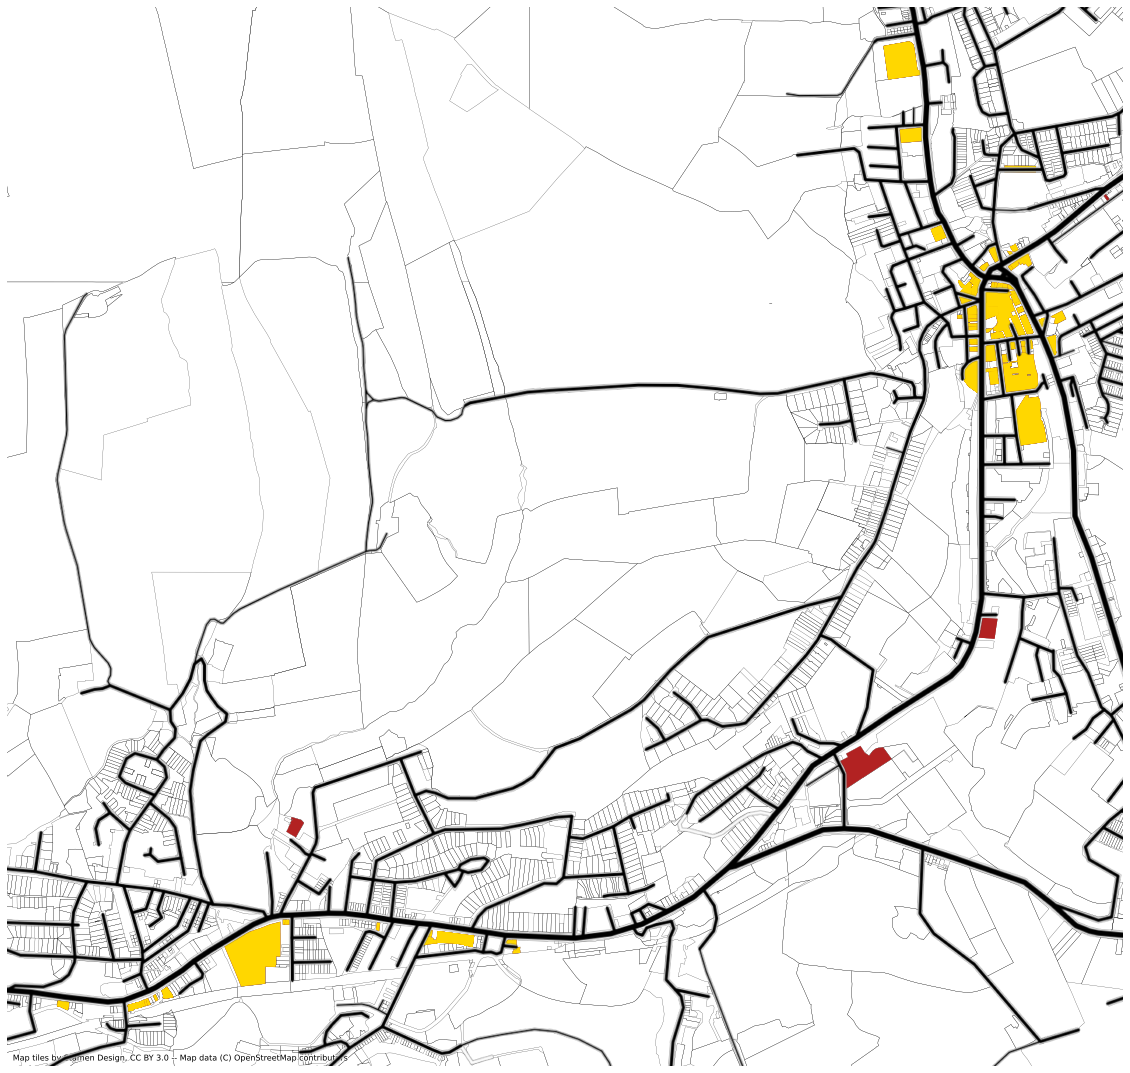

In [123]:
fig, ax=plt.subplots(1,
                     figsize=(20,20)
                    )

ax.set_xlim(xlim_hs)
ax.set_ylim(ylim_hs)

polygons.plot(ax=ax, 
              facecolor='None', 
              edgecolor='black', 
              linewidth=0.2,
             )



retail_poly.plot(ax=ax,
                 color='firebrick',
                )

high_st_poly.plot(ax=ax, 
                  color='gold',
                 )
         

cx.add_basemap(ax=ax,
               crs=filt.crs,
               source=cx.providers.Stamen.TonerLines,
              )



ax.set_axis_off()
plt.savefig('6 HS Zoom')

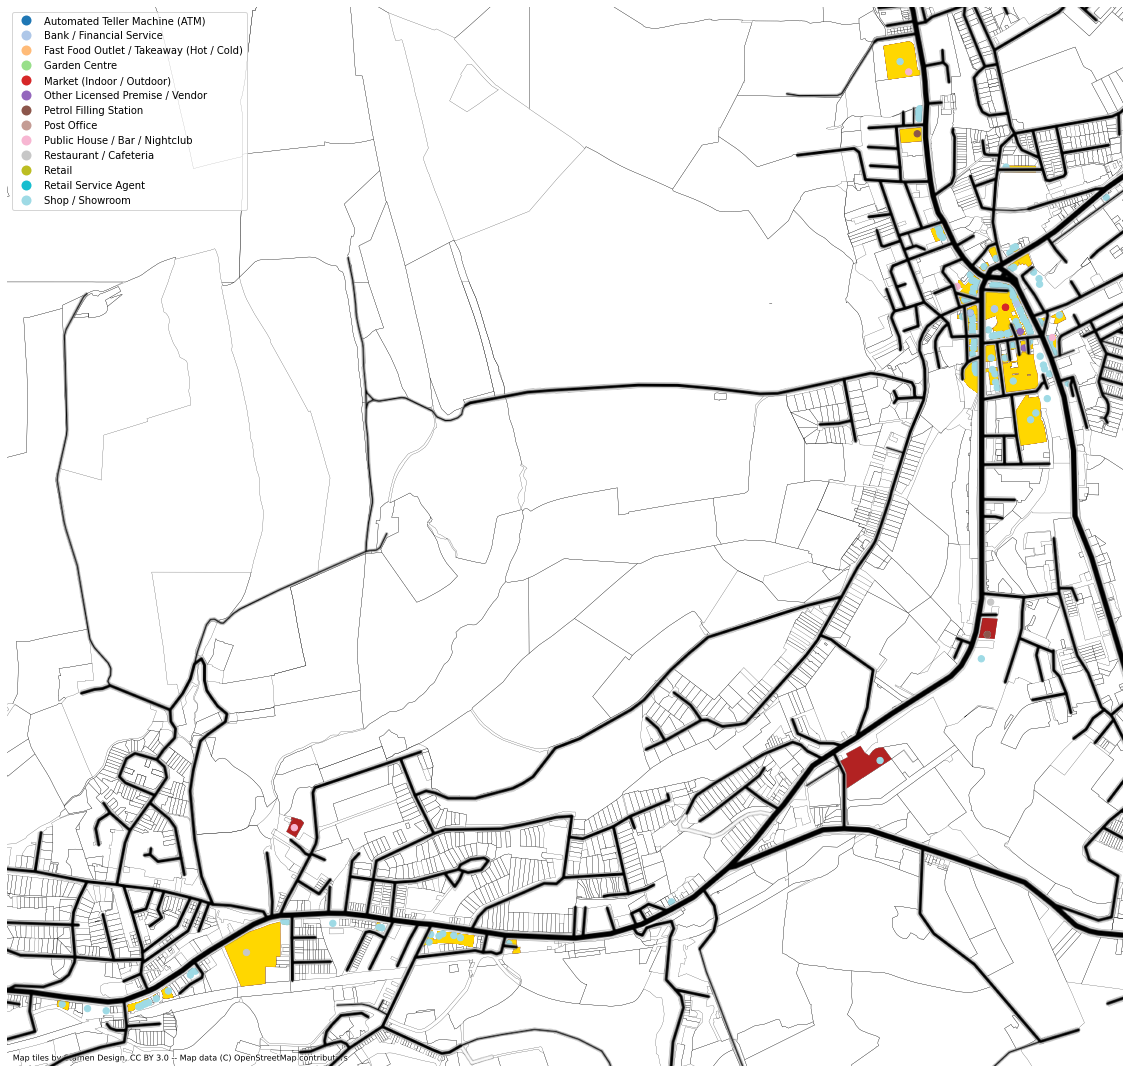

In [124]:
fig, ax=plt.subplots(1,
                     figsize=(20,20)
                    )

ax.set_xlim(xlim_hs)
ax.set_ylim(ylim_hs)

polygons.plot(ax=ax, 
              facecolor='None', 
              edgecolor='black', 
              linewidth=0.2,
             )



retail_poly.plot(ax=ax,
                 color='firebrick'
                )

high_st_poly.plot(ax=ax, 
                  color='gold',
                 )

filt_code.plot(ax=ax,
               column='Class_Desc',
               cmap='tab20',
               categorical=True,
               markersize=40,
               legend=True,
               alpha=1
              )
         

cx.add_basemap(ax=ax,
               crs=filt.crs,
               source=cx.providers.Stamen.TonerLines,
              )



ax.set_axis_off()
plt.savefig('7 Retail Categories')